# **Techniques to 'stationarize' a time series**

A data sample is generate by a Normal distribution with varying expectation and variance over time. Both have a cosine trend, and the maximum variance and expectation is reached at half of the total time. The sample rate is 1 samp/s for a total of 200 seconds.

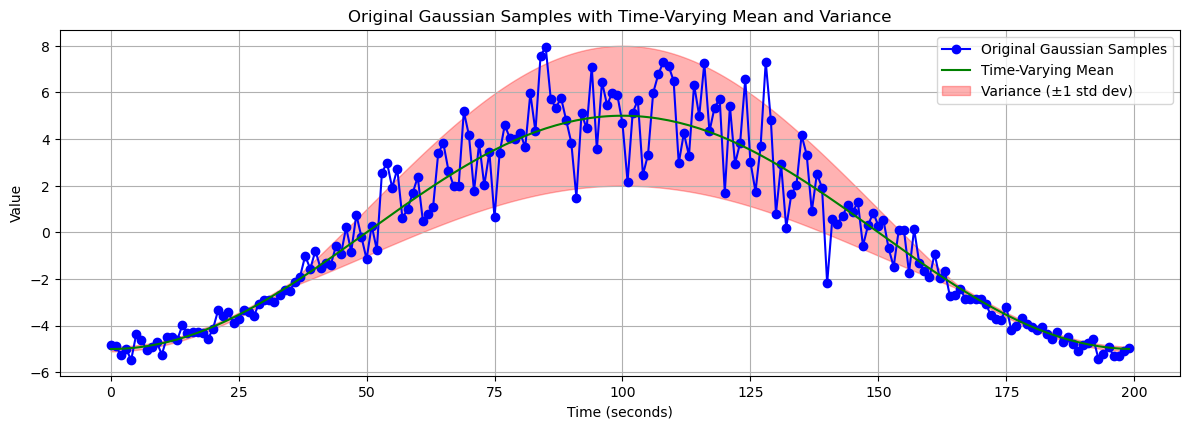

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Parameters for time and sampling
sample_time = 1  # Sampling every 10 seconds
total_time = 200  # Total time duration of the simulation (seconds)
times = np.arange(0, total_time, sample_time)

# Define functions for time-varying mean and variance
def mean_function(t):
    return 5 * np.cos(2 * np.pi * t / total_time - np.pi)  # Mean varies with cosine

def variance_function(t):
    return np.maximum(0.1, 1 + 2 * np.cos(2 * np.pi * t / total_time - np.pi))  # Ensure variance is non-negative

# Generate Gaussian random variables with time-varying mean and variance
gaussian_samples = []
means = []
variances = []

for t in times:
    mu = mean_function(t)
    sigma = np.sqrt(variance_function(t))  # Variance must be non-negative
    sample = np.random.normal(mu, sigma)
    
    gaussian_samples.append(sample)
    means.append(mu)
    variances.append(sigma**2)

# Convert list to numpy array for detrending
gaussian_samples = np.array(gaussian_samples)

# Convert the gaussian_samples to a pandas Series for rolling calculations
gaussian_samples_series = pd.Series(gaussian_samples)

# Plotting the original Gaussian samples and the detrended series
plt.figure(figsize=(12, 8))

# Plot the original random Gaussian samples
plt.subplot(2, 1, 1)
plt.plot(times, gaussian_samples, 'o-', label="Original Gaussian Samples", color='blue')
plt.plot(times, means, label="Time-Varying Mean", color='green')
plt.fill_between(times, np.array(means) - np.array(variances), np.array(means) + np.array(variances), 
                 color='red', alpha=0.3, label="Variance (±1 std dev)")
plt.title('Original Gaussian Samples with Time-Varying Mean and Variance')
plt.xlabel('Time (seconds)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## **Stationarity tests**

Augmented Dickey-Fuller ​and Kwiatkowski-Phillips-Schmidt-Shin​ are used.

In [9]:
from statsmodels.tsa.stattools import adfuller, kpss

# NOTE: a slightly change can occur on the output values when running the code again

# Augmented Dickey-Fuller test
adf_result = adfuller(gaussian_samples_series.dropna())  # dropna to remove any NaN values
print("Augmented Dickey-Fuller Test:")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

# KPSS test
kpss_result = kpss(gaussian_samples_series.dropna(), regression='c')  # 'c' for constant, 'ct' for constant + trend
print("\nKPSS Test:")
print(f"KPSS Statistic: {kpss_result[0]}")
print(f"p-value: {kpss_result[1]}")
print(f"Critical Values: {kpss_result[3]}")

Augmented Dickey-Fuller Test:
ADF Statistic: -0.7912150893167901
p-value: 0.8216889582760254
Critical Values: {'1%': -3.4654311561944873, '5%': -2.8769570530458792, '10%': -2.574988319755886}

KPSS Test:
KPSS Statistic: 0.5248870542594278
p-value: 0.036061474265894636
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


**DISCUSSION:**

The ADF test checks for the presence of a unit root, which indicates non-stationarity. The null hypothesis for the ADF test is that the time series has a unit root (i.e., it is non-stationary).

- p-value (0.775): This high p-value is well above the common significance threshold (0.05). It indicates that we fail to reject the null hypothesis, meaning there is insufficient evidence to conclude that the series is stationary. In other words, the test suggests that the series is non-stationary.

- ADF Statistic (-0.938): This is compared against the critical values for different confidence levels (1%, 5%, 10%). Since the ADF statistic (-0.938) is greater than the critical values at all levels (e.g., -3.466 at 1%), we also fail to reject the null hypothesis.

**Conclusion from ADF:** The ADF test suggests that the time series is non-stationary.

The KPSS test checks for stationarity. The null hypothesis for the KPSS test is that the time series is stationary. The alternative hypothesis is that the series is not stationary (has a unit root).

- p-value (0.036): This low p-value is below the typical significance level (0.05). Therefore, we reject the null hypothesis, meaning there is evidence that the series is non-stationary.

- KPSS Statistic (0.523): We compare this against the critical values. The statistic falls between the 5% critical value (0.463) and the 2.5% critical value (0.574). This suggests that the series is non-stationary at the 5% significance level, but it becomes less conclusive as we approach higher levels of significance.

**Conclusion from KPSS:** The KPSS test also suggests that the time series is non-stationary.

## **Detrending With A Polynomial Regression**

The purpose is to remove the expectation trend from the time series. To do so, we use detrend(). The order specify polynomial order of the trend to be removed, e.g. order=0: it removes the constant.

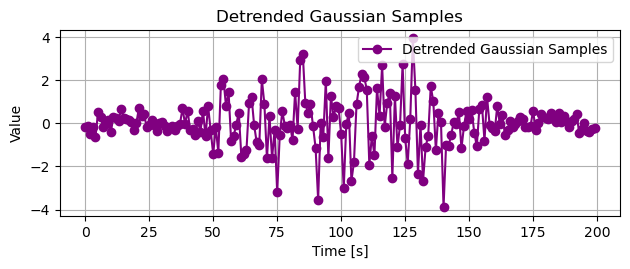

In [4]:
from statsmodels.tsa.tsatools import detrend

# Detrending using statsmodels (removes linear trend by default when order=0)
detrended_samples = detrend(gaussian_samples, order=4)

# Plot the detrended Gaussian samples
plt.subplot(2, 1, 2)
plt.plot(times, detrended_samples, 'o-', label="Detrended Gaussian Samples", color='purple')
plt.title('Detrended Gaussian Samples')
plt.xlabel('Time [s]')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## **Detrending With A Moving Average Model**

When you trend changes over time, you can use a moving average model to smooth out the trend. This model calculates the average value of the data over a certain window and subtracts it from each data point, resulting in a smoothed version of the time series.

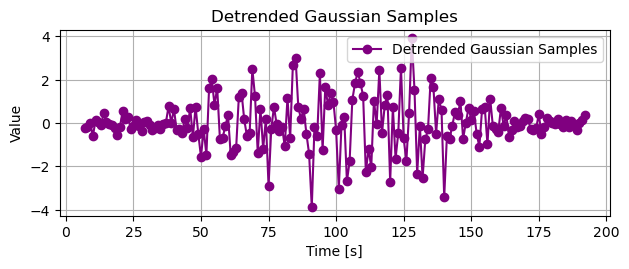

In [5]:
# Apply rolling mean with a window size of your choice (e.g., 10 in this case)
window_size = 15 
rolling_mean = gaussian_samples_series.rolling(window=window_size, center=True).mean()

# Detrend by subtracting the rolling mean from the original series
detrended_samples = gaussian_samples_series - rolling_mean

# Plot the detrended Gaussian samples
plt.subplot(2, 1, 2)
plt.plot(times, detrended_samples, 'o-', label="Detrended Gaussian Samples", color='purple')
plt.title('Detrended Gaussian Samples')
plt.xlabel('Time [s]')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## **Box Cox Transformation**

Box-Cox transformation is a technique used to stabilize the variance of a variable and make it more normally distributed. It is commonly applied when dealing with data that violates the assumption of constant variance in linear regression or other statistical models

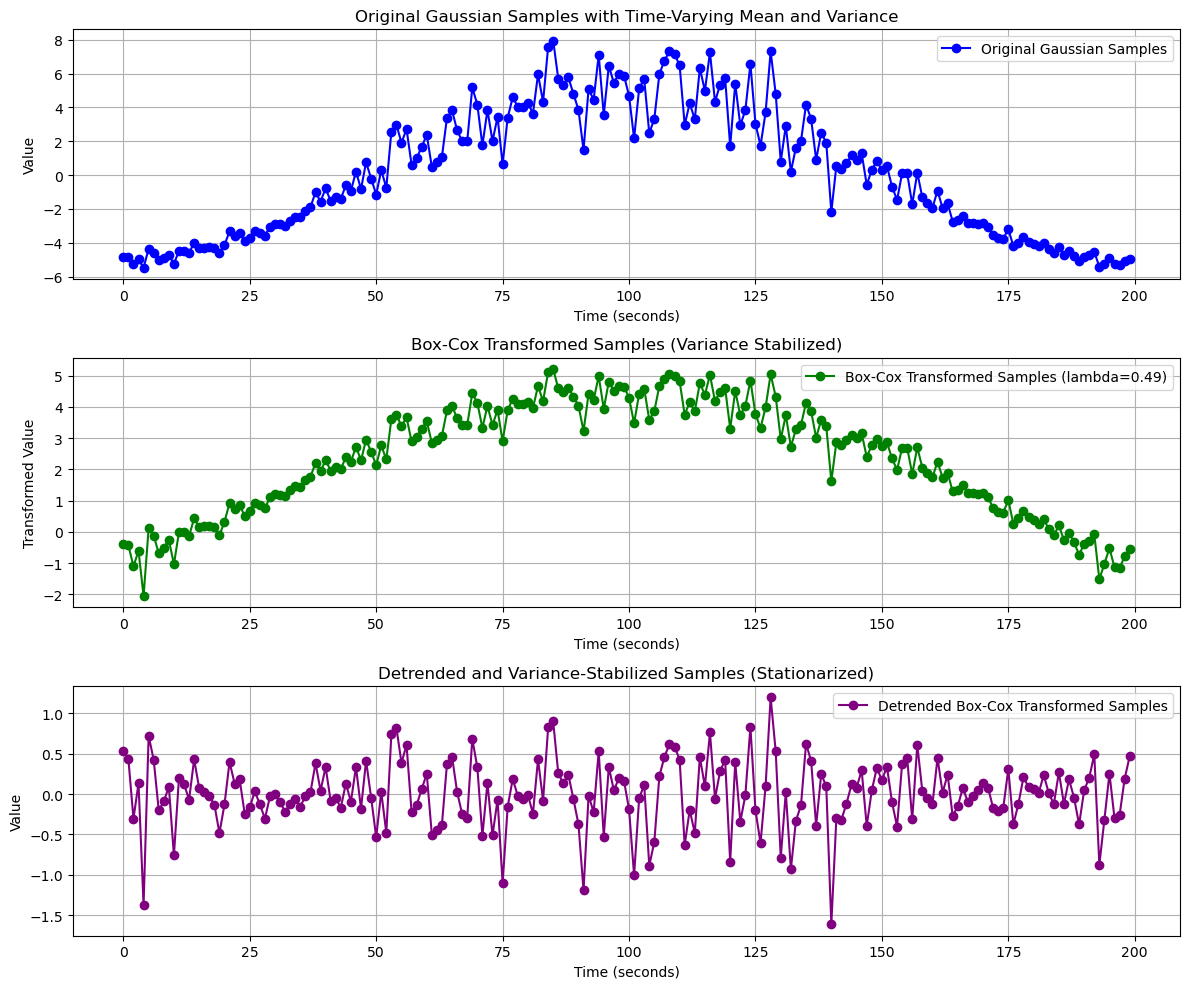

In [6]:
from scipy.stats import boxcox

# Step 1: Stabilize variance using Box-Cox transformation
# We add a small positive constant to avoid log(0) issues
shifted_samples = gaussian_samples - np.min(gaussian_samples) + 1e-6  # Ensure data is positive
boxcox_transformed_samples, lambda_value = boxcox(shifted_samples)

# Step 2: Detrending the Box-Cox transformed data
detrended_samples = detrend(boxcox_transformed_samples, order=4)  # Removing a linear trend

# Plotting the results
plt.figure(figsize=(12, 10))

# Plot the original samples
plt.subplot(3, 1, 1)
plt.plot(times, gaussian_samples, 'o-', label="Original Gaussian Samples", color='blue')
plt.title('Original Gaussian Samples with Time-Varying Mean and Variance')
plt.xlabel('Time (seconds)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Plot the Box-Cox transformed samples (variance stabilized)
plt.subplot(3, 1, 2)
plt.plot(times, boxcox_transformed_samples, 'o-', label=f"Box-Cox Transformed Samples (lambda={lambda_value:.2f})", color='green')
plt.title('Box-Cox Transformed Samples (Variance Stabilized)')
plt.xlabel('Time (seconds)')
plt.ylabel('Transformed Value')
plt.legend()
plt.grid(True)

# Plot the detrended Box-Cox transformed samples
plt.subplot(3, 1, 3)
plt.plot(times, detrended_samples, 'o-', label="Detrended Box-Cox Transformed Samples", color='purple')
plt.title('Detrended and Variance-Stabilized Samples (Stationarized)')
plt.xlabel('Time (seconds)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [7]:
# Augmented Dickey-Fuller test
detrended_samples_series = pd.Series(detrended_samples);

adf_result = adfuller(detrended_samples_series.dropna())  # dropna to remove any NaN values
print("Augmented Dickey-Fuller Test:")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

# KPSS test
kpss_result = kpss(detrended_samples_series.dropna(), regression='c')  # 'c' for constant, 'ct' for constant + trend
print("\nKPSS Test:")
print(f"KPSS Statistic: {kpss_result[0]}")
print(f"p-value: {kpss_result[1]}")
print(f"Critical Values: {kpss_result[3]}")

Augmented Dickey-Fuller Test:
ADF Statistic: -13.345527508922402
p-value: 5.805198809873188e-25
Critical Values: {'1%': -3.4636447617687436, '5%': -2.8761761179270766, '10%': -2.57457158581854}

KPSS Test:
KPSS Statistic: 0.018902495825851514
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/tmp/ipykernel_1102/725480592.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(detrended_samples_series.dropna(), regression='c')  # 'c' for constant, 'ct' for constant + trend


**DISCUSSION:**

ADF test:
- ADF Statistic (-14.002): This value is much more negative than all the critical values at the 1%, 5%, and 10% levels.
- p-value (3.84e-26): The p-value is extremely small, much smaller than the common significance level (0.05).

**Conclusion from ADF:** Since the ADF statistic is highly negative and the p-value is close to zero, you can reject the null hypothesis of non-stationarity. The series is stationary based on the ADF test.

KPSS test:

- KPSS Statistic (0.0339): This is much smaller than all the critical values.
- p-value (0.1): The p-value is large, indicating that the null hypothesis (stationarity) cannot be rejected.
  
**Conclusion from KPSS:** The KPSS statistic is very low, and the p-value is at least 0.1 (or even larger), suggesting that the series is stationary.

## References:

https://forecastegy.com/posts/detrending-time-series-data-python/

https://ogre51.medium.com/transforming-data-for-statistical-analysis-the-power-of-box-cox-transformation-a4a059ad2397#:~:text=Box%2DCox%20transformation%20is%20a,regression%20or%20other%20statistical%20models.